In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(rc={'figure.figsize':(12, 6)})

# 데이터 경로 설정 (상대 경로)
DATA_DIR = './open_track1'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
MATCH_INFO_PATH = os.path.join(DATA_DIR, 'match_info.csv')
TEST_META_PATH = os.path.join(DATA_DIR, 'test.csv')

# 데이터 로드
print("데이터 로딩 중...")
train_df = pd.read_csv(TRAIN_PATH)
match_info_df = pd.read_csv(MATCH_INFO_PATH)
test_meta_df = pd.read_csv(TEST_META_PATH)

print(f"Train Data Shape: {train_df.shape}")
print(f"Match Info Shape: {match_info_df.shape}")
print(f"Test Meta Shape: {test_meta_df.shape}")

display(train_df.head(3))

데이터 로딩 중...
Train Data Shape: (356721, 15)
Match Info Shape: (228, 17)
Test Meta Shape: (2414, 3)


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1


In [3]:
# 데이터 기본 정보 출력
print("데이터프레임 정보:")
print(train_df.info())

# 결측치 비율 계산
missing_ratio = train_df.isnull().mean() * 100
missing_cols = missing_ratio[missing_ratio > 0]

print("\n결측치 비율 (%):")
if len(missing_cols) > 0:
    print(missing_cols.sort_values(ascending=False))
else:
    print("결측치 없음")

# 종료 좌표가 없는 이벤트 타입 확인
no_end_coords = train_df[train_df['end_x'].isnull()]['type_name'].unique()
print(f"\n종료 좌표(end_x/y)가 없는 이벤트 타입 목록:\n{no_end_coords}")

데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356721 entries, 0 to 356720
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   game_id       356721 non-null  int64  
 1   period_id     356721 non-null  int64  
 2   episode_id    356721 non-null  int64  
 3   time_seconds  356721 non-null  float64
 4   team_id       356721 non-null  int64  
 5   player_id     356721 non-null  int64  
 6   action_id     356721 non-null  int64  
 7   type_name     356721 non-null  object 
 8   result_name   216467 non-null  object 
 9   start_x       356721 non-null  float64
 10  start_y       356721 non-null  float64
 11  end_x         356721 non-null  float64
 12  end_y         356721 non-null  float64
 13  is_home       356721 non-null  bool   
 14  game_episode  356721 non-null  object 
dtypes: bool(1), float64(5), int64(6), object(3)
memory usage: 38.4+ MB
None

결측치 비율 (%):
result_name    39.317562
dtype: float64


In [4]:
# 1. 어떤 이벤트들이 결측치를 가지고 있는지 확인
print("🔍 이벤트 타입별 end_x 결측치 개수:")
missing_events = train_df[train_df['end_x'].isnull()]['type_name'].value_counts()
display(missing_events)

# 2. 비율로 확인 (해당 이벤트 발생 건수 중 몇 %가 결측인지)
print("\n📊 이벤트 타입별 결측 비율 (상위 10개):")
total_events = train_df['type_name'].value_counts()
missing_ratio = (missing_events / total_events).sort_values(ascending=False)
display(missing_ratio.head(10))

🔍 이벤트 타입별 end_x 결측치 개수:


Series([], Name: count, dtype: int64)


📊 이벤트 타입별 결측 비율 (상위 10개):


type_name
Aerial Clearance   NaN
Block              NaN
Carry              NaN
Catch              NaN
Clearance          NaN
Cross              NaN
Deflection         NaN
Duel               NaN
Error              NaN
Foul               NaN
Name: count, dtype: float64

In [5]:
# [전처리 솔루션] 결측치 처리: 이동하지 않는 이벤트는 종료 좌표를 시작 좌표와 동일하게 설정
# 주의: 이 작업은 train과 test 데이터 모두에 적용해야 합니다.

print("🔧 결측치 보정 중 (NaN -> Start Coords)...")

# Train 데이터 보정
train_df['end_x'] = train_df['end_x'].fillna(train_df['start_x'])
train_df['end_y'] = train_df['end_y'].fillna(train_df['start_y'])

# 확인
print(f"보정 후 Train 결측치 수: {train_df['end_x'].isnull().sum()}")

🔧 결측치 보정 중 (NaN -> Start Coords)...
보정 후 Train 결측치 수: 0


🚀 공간 분석 시작: 히트맵 및 이벤트 패턴 시각화 (샘플링 적용)
⚠️ 데이터가 356,721개로 많아서 100,000개만 샘플링하여 시각화합니다.


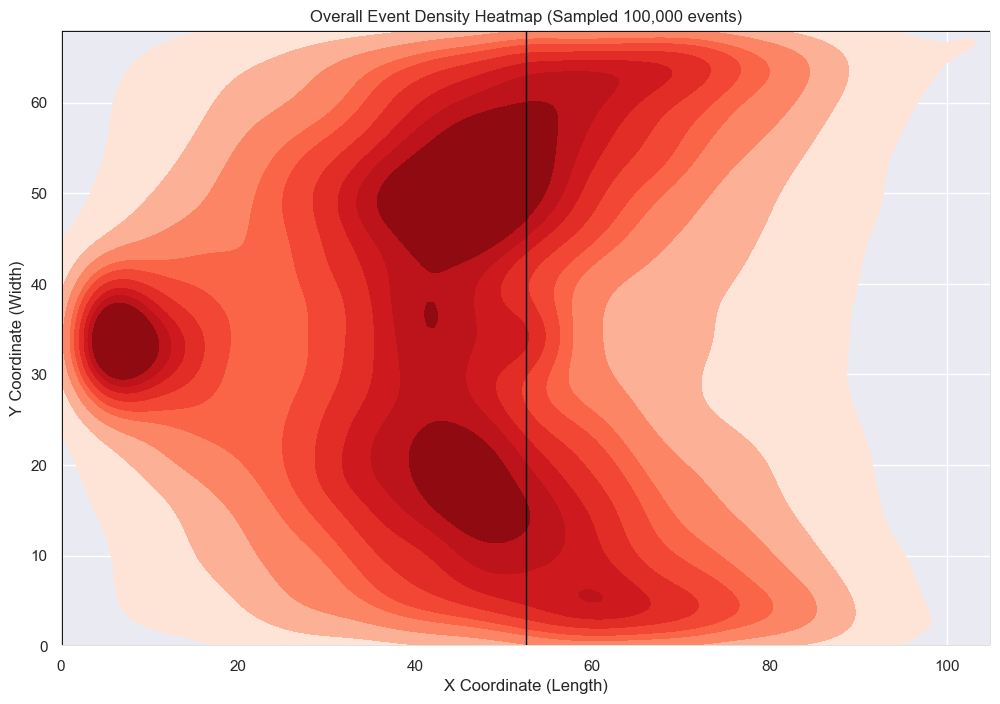

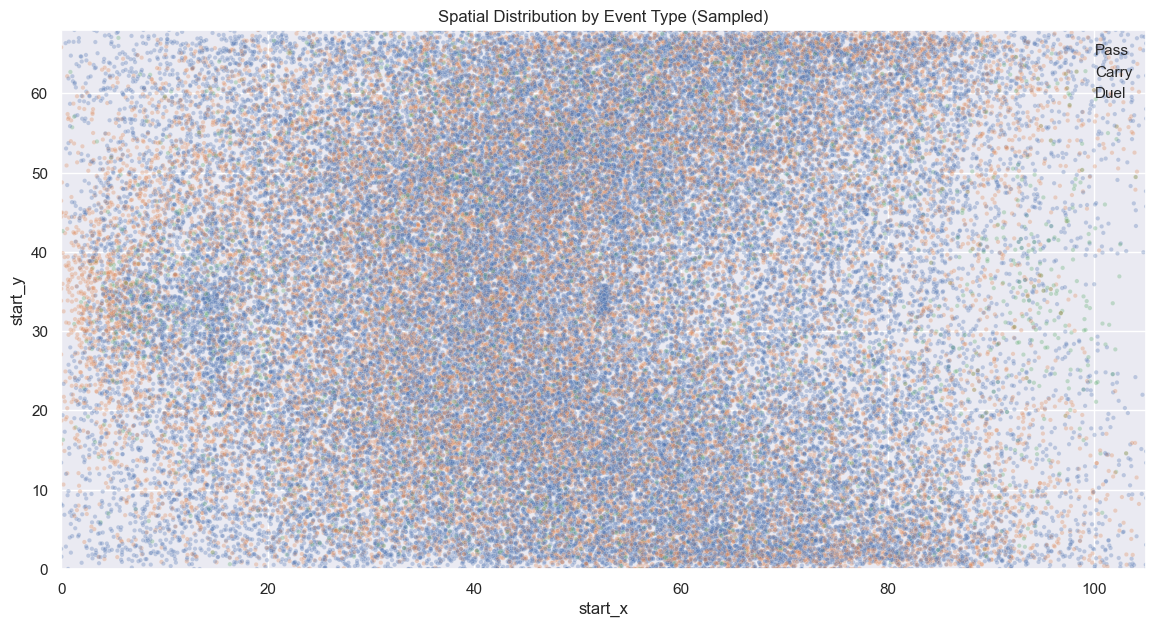

In [6]:
# ==========================================
# 2. 공간 분석 (Spatial Analysis) - 고속 버전
# ==========================================
print("🚀 공간 분석 시작: 히트맵 및 이벤트 패턴 시각화 (샘플링 적용)")

# 데이터가 너무 많으면 시각화가 느리므로, 10만 개만 랜덤하게 뽑아서 그림
SAMPLE_SIZE = 100000

if len(train_df) > SAMPLE_SIZE:
    print(f"⚠️ 데이터가 {len(train_df):,}개로 많아서 {SAMPLE_SIZE:,}개만 샘플링하여 시각화합니다.")
    plot_data = train_df.sample(n=SAMPLE_SIZE, random_state=42)
else:
    plot_data = train_df

# 1. 전체 이벤트 발생 위치 히트맵
plt.figure(figsize=(12, 8))
# thresh=0.05: 너무 옅은 밀도는 그리지 않음 (속도 향상)
sns.kdeplot(data=plot_data, x='start_x', y='start_y', fill=True, cmap='Reds', thresh=0.05)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.title(f'Overall Event Density Heatmap (Sampled {len(plot_data):,} events)')
plt.xlabel('X Coordinate (Length)')
plt.ylabel('Y Coordinate (Width)')

# 경기장 라인(대략적) 추가
plt.plot([0, 105, 105, 0, 0], [0, 0, 68, 68, 0], color='black', linewidth=2)
plt.plot([52.5, 52.5], [0, 68], color='black', linewidth=1) # 중앙선
plt.show()

# 2. 주요 이벤트별(Pass, Shot, Duel) 위치 비교
top_events = ['Pass', 'Duel', 'Carry']
target_df = plot_data[plot_data['type_name'].isin(top_events)]

plt.figure(figsize=(14, 7))
# s=10: 점 크기를 작게 설정
sns.scatterplot(data=target_df, x='start_x', y='start_y', hue='type_name', alpha=0.3, s=10)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.title('Spatial Distribution by Event Type (Sampled)')
plt.legend(loc='upper right')
plt.show()

1. 첫 번째 그래프: 전체 이벤트 밀도 (Heatmap)
붉은색 등고선(또는 구름) 처럼 보이는 그래프입니다.

무엇을 보여주나요?: 선수들이 경기장에서 어느 위치에서 가장 많이 활동했는지를 보여줍니다.

X축 (0 ~ 105): 경기장 길이입니다. 왼쪽(0)이 우리 진영 골대, 오른쪽(105)이 상대 진영 골대 방향입니다.

Y축 (0 ~ 68): 경기장 폭입니다.

진한 빨간색 영역 (Hot Zone): 이벤트가 가장 많이 발생한 곳입니다.

보통 **중앙선 부근(X=52.5, Y=34)**이 가장 진하게 나옵니다. (패스, 빌드업이 주로 일어나는 곳)

양쪽 **사이드라인(위/아래 끝)**에도 붉은 영역이 있다면, 윙 플레이나 스로인이 많았다는 뜻입니다.

**골대 앞(X=100 부근)**이 진하다면 공격적인 경기가 많았다는 증거입니다.

두 번째 그래프: 이벤트 종류별 분포 (Scatter Plot)
여러 가지 색깔의 점들이 찍혀 있는 그래프입니다.

무엇을 보여주나요?: Pass(패스), Duel(경합), Carry(드리블) 같은 주요 행동들이 각각 어디서 주로 일어나는지 비교합니다.

해석 포인트:

Pass (패스): 경기장 전체에 고르게 퍼져 있을 것입니다.

Duel (경합): 공중볼 경합이 많은 중앙선 부근이나, 롱볼이 떨어지는 위치에 점이 몰려 있을 수 있습니다.

Carry (드리블): 수비가 빽빽한 중앙보다는 공간이 넓은 측면이나 하프 스페이스에 분포하는지 확인해 보면 좋을 것 같습니다.

In [7]:
# ==========================================
# 3. 좌표 무결성 점검 및 보정 (Integrity Check & Fix)
# ==========================================
print("좌표 데이터 범위 점검 및 보정 (0~105, 0~68)")

# 1. 범위 벗어나는 데이터 개수 확인
# X축(길이): 0 ~ 105, Y축(폭): 0 ~ 68
out_of_bound_x = train_df[(train_df['start_x'] < 0) | (train_df['start_x'] > 105) | 
                          (train_df['end_x'] < 0) | (train_df['end_x'] > 105)]
out_of_bound_y = train_df[(train_df['start_y'] < 0) | (train_df['start_y'] > 68) | 
                          (train_df['end_y'] < 0) | (train_df['end_y'] > 68)]

print(f"보정 전 - X축 범위 벗어난 데이터: {len(out_of_bound_x)}개")
print(f"보정 전 - Y축 범위 벗어난 데이터: {len(out_of_bound_y)}개")

# 2. 보정 실행 (Clipping)
# 0보다 작으면 0으로, 105(68)보다 크면 105(68)로 강제 변환
train_df['start_x'] = train_df['start_x'].clip(0, 105)
train_df['start_y'] = train_df['start_y'].clip(0, 68)
train_df['end_x'] = train_df['end_x'].clip(0, 105)
train_df['end_y'] = train_df['end_y'].clip(0, 68)

print("범위 보정(Clipping) 완료")

# 3. 보정 결과 재확인
out_of_bound_x_after = train_df[(train_df['start_x'] < 0) | (train_df['start_x'] > 105) | 
                                (train_df['end_x'] < 0) | (train_df['end_x'] > 105)]
out_of_bound_y_after = train_df[(train_df['start_y'] < 0) | (train_df['start_y'] > 68) | 
                                (train_df['end_y'] < 0) | (train_df['end_y'] > 68)]

print(f"보정 후 - X축 범위 벗어난 데이터: {len(out_of_bound_x_after)}개")
print(f"보정 후 - Y축 범위 벗어난 데이터: {len(out_of_bound_y_after)}개")

좌표 데이터 범위 점검 및 보정 (0~105, 0~68)
보정 전 - X축 범위 벗어난 데이터: 0개
보정 전 - Y축 범위 벗어난 데이터: 0개
범위 보정(Clipping) 완료
보정 후 - X축 범위 벗어난 데이터: 0개
보정 후 - Y축 범위 벗어난 데이터: 0개


🔗 시퀀스 분석 1: 에피소드 길이(행동 수) 분석


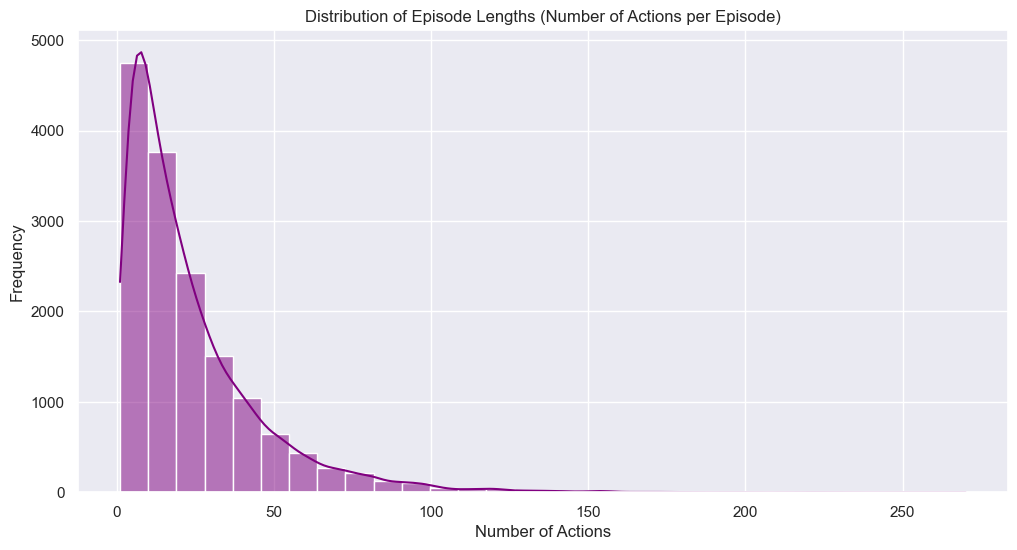

평균 에피소드 길이: 23.11회
최대 에피소드 길이: 270회


In [11]:
# ==========================================
# 3. 시퀀스 & 에피소드 분석 (Sequential Analysis)
# ==========================================
print("🔗 시퀀스 분석 1: 에피소드 길이(행동 수) 분석")

# 에피소드별 행동 개수 카운트
episode_lengths = train_df.groupby('game_episode')['action_id'].count()

# 시각화
plt.figure(figsize=(12, 6))
sns.histplot(episode_lengths, bins=30, kde=True, color='purple')
plt.title('Distribution of Episode Lengths (Number of Actions per Episode)')
plt.xlabel('Number of Actions')
plt.ylabel('Frequency')
plt.show()

print(f"평균 에피소드 길이: {episode_lengths.mean():.2f}회")
print(f"최대 에피소드 길이: {episode_lengths.max()}회")

## 🔗 3-2. 시퀀스 분석: 행동 전이(Transition) 패턴 파악

**"직전의 행동이 다음 행동을 결정한다?"**
축구는 연속적인 흐름의 스포츠입니다. 이 분석은 **어떤 행동(Event) 다음에 어떤 행동이 주로 이어지는지**를 확률적으로 시각화하여 플레이의 맥락(Context)을 파악합니다.

### 📋 분석 목적
* **플레이 흐름 파악:** 특정 이벤트(`Previous Action`) 발생 후, 선수가 어떤 선택(`Current Action`)을 가장 많이 하는지 경향성을 확인합니다.
* **주요 패턴 발견:**
    * `Pass` → `Pass` (빌드업 중심)
    * `Pass` → `Carry` (공간 확보 중심)
    * `Duel` (경합) 승리 후 → `Pass` or `Shot`?
* **Feature Engineering 힌트:** 특정 시퀀스(예: 패스 연결 후 슛)가 예측 좌표에 미치는 영향을 파악하여 모델 변수로 활용할 수 있습니다.

### 📊 시각화 방법: 전이 행렬(Transition Matrix) 히트맵
* **행(Row, Y축):** 직전 행동 (Previous Action Type)
* **열(Col, X축):** 현재 행동 (Current Action Type)
* **값(Value):** 확률 (0.0 ~ 1.0, 행별 합계는 1)

> **💡 해석 팁:**
> * 히트맵의 **색이 진할수록** 해당 패턴이 경기 중에 자주 발생한다는 의미입니다.
> * 대각선(Diagonal)이 진하다면, 동일한 행동이 반복되는 경향(예: 드리블 돌파 지속)이 강하다는 뜻입니다.

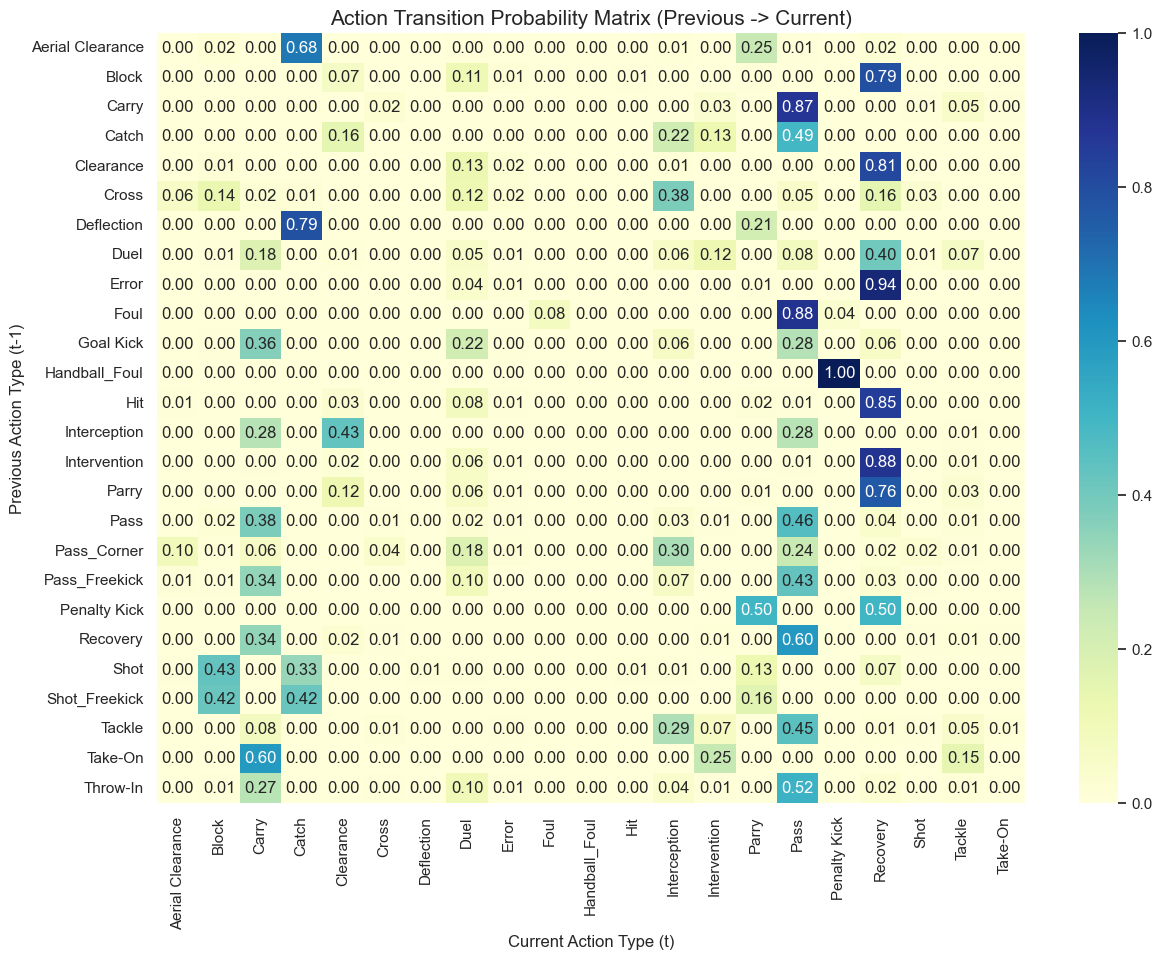

In [10]:
# ==========================================
# 3-2. 시퀀스 분석: 행동 전이(Transition) 히트맵
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 직전 행동(Previous Action) 컬럼 생성
# 데이터 정렬: 게임 > 에피소드 > 시간 순서 (섞임 방지)
train_df = train_df.sort_values(['game_id', 'episode_id', 'action_id'])
# 에피소드별로 그룹화하여 한 칸씩 미룸(Shift)
train_df['prev_type_name'] = train_df.groupby('game_episode')['type_name'].shift(1)

# 2. 전이 행렬(Transition Matrix) 생성
# normalize='index': 행(Row) 기준으로 확률 계산 (합이 1이 되도록)
transition_matrix = pd.crosstab(train_df['prev_type_name'], train_df['type_name'], normalize='index')

# 3. 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Action Transition Probability Matrix (Previous -> Current)', fontsize=15)
plt.ylabel('Previous Action Type (t-1)', fontsize=12)
plt.xlabel('Current Action Type (t)', fontsize=12)
plt.show()

## 🛡️ 3. 좌표 무결성 점검 및 보정 (Integrity Check & Clipping)

**"데이터가 경기장 밖으로 나갔다면?"**
센서 오류나 기록 실수로 인해 좌표값이 경기장 규격(0~105, 0~68)을 벗어나는 경우가 있을 수 있습니다. 이러한 '이상치(Outlier)'는 모델 학습에 방해가 되므로, 경기장 라인 안으로 강제 이동(Clipping)시켜주는 작업이 필요합니다.

### 📋 작업 내용
1.  **범위 확인:** `start_x`, `start_y`, `end_x`, `end_y` 중 허용 범위를 벗어난 데이터가 있는지 확인합니다.
2.  **Clipping (보정):**
    * 0보다 작은 값 ➔ **0**으로 변경
    * 105보다 큰 X값 ➔ **105**로 변경
    * 68보다 큰 Y값 ➔ **68**로 변경

In [12]:
# ==========================================
# 3. 좌표 무결성 점검 및 보정 (Integrity Check & Fix)
# ==========================================
print("⚽ 좌표 데이터 범위 점검 및 보정 (0~105, 0~68)")

# 1. 범위 벗어나는 데이터 개수 확인
# X축(길이): 0 ~ 105, Y축(폭): 0 ~ 68
out_of_bound_x = train_df[(train_df['start_x'] < 0) | (train_df['start_x'] > 105) | 
                          (train_df['end_x'] < 0) | (train_df['end_x'] > 105)]
out_of_bound_y = train_df[(train_df['start_y'] < 0) | (train_df['start_y'] > 68) | 
                          (train_df['end_y'] < 0) | (train_df['end_y'] > 68)]

print(f"보정 전 - X축 범위 벗어난 데이터: {len(out_of_bound_x)}개")
print(f"보정 전 - Y축 범위 벗어난 데이터: {len(out_of_bound_y)}개")

# 2. 보정 실행 (Clipping)
# 0보다 작으면 0으로, 105(68)보다 크면 105(68)로 강제 변환
train_df['start_x'] = train_df['start_x'].clip(0, 105)
train_df['start_y'] = train_df['start_y'].clip(0, 68)
train_df['end_x'] = train_df['end_x'].clip(0, 105)
train_df['end_y'] = train_df['end_y'].clip(0, 68)

print("🔧 범위 보정(Clipping) 완료")

# 3. 보정 결과 재확인 (0개가 나와야 정상)
out_of_bound_x_after = train_df[(train_df['start_x'] < 0) | (train_df['start_x'] > 105) | 
                                (train_df['end_x'] < 0) | (train_df['end_x'] > 105)]
out_of_bound_y_after = train_df[(train_df['start_y'] < 0) | (train_df['start_y'] > 68) | 
                                (train_df['end_y'] < 0) | (train_df['end_y'] > 68)]

print(f"✅ 보정 후 - X축 범위 벗어난 데이터: {len(out_of_bound_x_after)}개")
print(f"✅ 보정 후 - Y축 범위 벗어난 데이터: {len(out_of_bound_y_after)}개")

⚽ 좌표 데이터 범위 점검 및 보정 (0~105, 0~68)
보정 전 - X축 범위 벗어난 데이터: 0개
보정 전 - Y축 범위 벗어난 데이터: 0개
🔧 범위 보정(Clipping) 완료
✅ 보정 후 - X축 범위 벗어난 데이터: 0개
✅ 보정 후 - Y축 범위 벗어난 데이터: 0개


## 🏟️ 4. 경기 컨텍스트 분석 (Match Context Analysis)

**"전반전과 후반전, 홈팀과 원정팀은 어떻게 다를까?"**
선수의 행동은 경기 시간과 상황에 따라 달라집니다. 체력이 떨어지는 후반전에는 패스 정확도가 떨어지거나, 홈팀이 더 공격적인 성향을 보일 수 있습니다.

### 📋 분석 목적
1.  **시간대별 패턴 (Temporal):** 전반전(`period_id=1`)과 후반전(`2`)의 이벤트 양상 비교.
2.  **팀별 스타일 (Team Profiling):** 팀(`team_id`)마다 패스, 드리블, 경합 비중이 어떻게 다른지 확인하여 팀 컬러 파악.
3.  **홈 어드밴티지 (Home Advantage):** 홈팀(`is_home=True`)이 원정팀보다 더 공격적인지(이벤트 수가 많은지) 확인.

🏟️ 경기 컨텍스트 분석: 시간, 팀, 홈/원정 여부


C:\Users\jwk72\AppData\Local\Temp\ipykernel_4032\2305863757.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='period_id', palette='coolwarm', ax=ax[0])
C:\Users\jwk72\AppData\Local\Temp\ipykernel_4032\2305863757.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='is_home', palette='pastel', ax=ax[1])


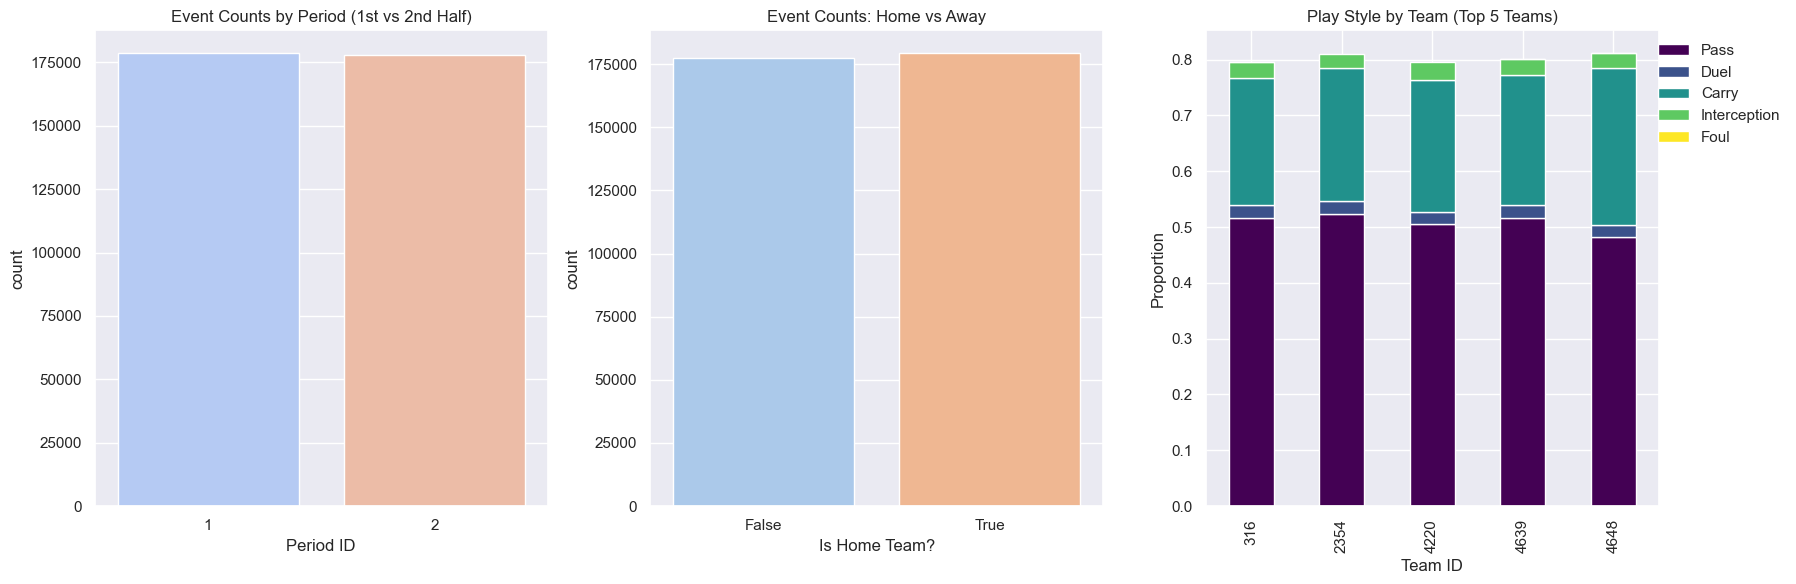

✅ 해석 팁:
- 전/후반 이벤트 수가 비슷하다면 체력적인 변수가 적을 수 있습니다.
- 홈팀(True) 막대가 더 높다면 홈 어드밴티지가 존재한다는 뜻입니다.
- 팀별 그래프에서 'Pass' 비율이 유독 높은 팀이 있다면 점유율 축구를 하는 팀일 수 있습니다.


In [13]:
# ==========================================
# 4. 경기 컨텍스트 분석 (Match Context Analysis)
# ==========================================
print("🏟️ 경기 컨텍스트 분석: 시간, 팀, 홈/원정 여부")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. 전/후반 이벤트 수 비교
sns.countplot(data=train_df, x='period_id', palette='coolwarm', ax=ax[0])
ax[0].set_title('Event Counts by Period (1st vs 2nd Half)')
ax[0].set_xlabel('Period ID')

# 2. 홈/원정 이벤트 수 비교
sns.countplot(data=train_df, x='is_home', palette='pastel', ax=ax[1])
ax[1].set_title('Event Counts: Home vs Away')
ax[1].set_xlabel('Is Home Team?')

# 3. 팀별 플레이 스타일 (이벤트 타입 비율) - 상위 5개 팀만
top_teams = train_df['team_id'].value_counts().head(5).index
team_play_style = pd.crosstab(train_df[train_df['team_id'].isin(top_teams)]['team_id'], 
                              train_df['type_name'], 
                              normalize='index')

# 주요 이벤트만 골라서 시각화 (가독성 위해)
main_events = ['Pass', 'Duel', 'Carry', 'Interception', 'Foul']
team_play_style[main_events].plot(kind='bar', stacked=True, ax=ax[2], colormap='viridis')
ax[2].set_title('Play Style by Team (Top 5 Teams)')
ax[2].set_xlabel('Team ID')
ax[2].set_ylabel('Proportion')
ax[2].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

print("✅ 해석 팁:")
print("- 전/후반 이벤트 수가 비슷하다면 체력적인 변수가 적을 수 있습니다.")
print("- 홈팀(True) 막대가 더 높다면 홈 어드밴티지가 존재한다는 뜻입니다.")
print("- 팀별 그래프에서 'Pass' 비율이 유독 높은 팀이 있다면 점유율 축구를 하는 팀일 수 있습니다.")

## 🛠️ Phase 3. 특성 공학 (Feature Engineering)

모델이 데이터를 더 잘 이해할 수 있도록, 축구 도메인 지식을 활용해 새로운 변수(Feature)를 만듭니다.

### 📋 생성할 변수 목록
1.  **기하학적 변수 (Geometry):**
    * **골대와의 거리/각도:** 득점 가능성과 패스 길이를 결정하는 핵심 요소.
    * **중앙선과의 거리:** 수비 압박 강도를 대변.
2.  **흐름 변수 (Lag Features):**
    * **직전 행동 정보:** 직전 행동의 종류(`prev_type_name`), 성공 여부(`prev_result`), 종료 위치(`prev_end_x/y`) 등.
    * **관성(Inertia):** 직전 행동이 끝난 위치와 현재 행동의 시작 위치 차이.

In [16]:
import pandas as pd
import numpy as np
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 1. 경로 설정
# 원본 데이터 위치 (읽기 전용)
RAW_DATA_DIR = './open_track1'
TRAIN_PATH = os.path.join(RAW_DATA_DIR, 'train.csv')
TEST_META_PATH = os.path.join(RAW_DATA_DIR, 'test.csv')

# 가공 데이터 저장 위치 (쓰기 전용)
PREPROCESS_DIR = './data_preprocess'

# 2. 폴더 생성 (없으면 만듦)
if not os.path.exists(PREPROCESS_DIR):
    os.makedirs(PREPROCESS_DIR)
    print(f"📂 새 폴더 생성 완료: {PREPROCESS_DIR}")
else:
    print(f"📂 폴더가 이미 존재합니다: {PREPROCESS_DIR}")

print(f"   - 원본 데이터 읽는 곳: {RAW_DATA_DIR}")
print(f"   - 가공 데이터 저장할 곳: {PREPROCESS_DIR}")

📂 폴더가 이미 존재합니다: ./data_preprocess
   - 원본 데이터 읽는 곳: ./open_track1
   - 가공 데이터 저장할 곳: ./data_preprocess


In [17]:
def calculate_dist_angle(df, x_col, y_col):
    """
    좌표(x, y)를 기준으로 골대 및 중앙점과의 거리/각도를 계산하는 함수
    """
    # 1. 골대(105, 34)까지의 거리
    df['dist_to_goal'] = np.sqrt((105 - df[x_col])**2 + (34 - df[y_col])**2)
    
    # 2. 골대까지의 각도 (도 단위)
    df['angle_to_goal'] = np.arctan2((34 - df[y_col]), (105 - df[x_col])) * (180 / np.pi)
    
    # 3. 경기장 중앙(52.5, 34)까지의 거리
    df['dist_to_center'] = np.sqrt((52.5 - df[x_col])**2 + (34 - df[y_col])**2)
    
    return df

print("✅ 함수 정의 완료")

✅ 함수 정의 완료


In [18]:
print("🔨 Train 데이터 가공 중...")

# 1. 원본 로드
train_df = pd.read_csv(TRAIN_PATH)

# 2. 정렬 (에피소드 내 순서 보장)
train_df = train_df.sort_values(['game_id', 'episode_id', 'action_id'])

# 3. Lag Feature (직전 행동) 생성
train_df['prev_type_name'] = train_df.groupby('game_episode')['type_name'].shift(1)
train_df['prev_end_x'] = train_df.groupby('game_episode')['end_x'].shift(1)
train_df['prev_end_y'] = train_df.groupby('game_episode')['end_y'].shift(1)

# 결측치(첫 번째 행동) 처리
train_df['prev_type_name'] = train_df['prev_type_name'].fillna('None')
train_df['prev_end_x'] = train_df['prev_end_x'].fillna(train_df['start_x'])
train_df['prev_end_y'] = train_df['prev_end_y'].fillna(train_df['start_y'])

# 4. 기하학적 피처 추가
train_df = calculate_dist_angle(train_df, 'start_x', 'start_y')

# 5. 최종 학습용 데이터 추출 (마지막 행동만)
train_last_actions = train_df.drop_duplicates(subset=['game_episode'], keep='last').copy()

# 6. 파일 저장 (새로운 폴더에)
save_path = os.path.join(PREPROCESS_DIR, 'train_enriched.csv')
train_last_actions.to_csv(save_path, index=False)

print(f"✅ Train 가공 완료! 저장됨: {save_path}")
display(train_last_actions.head(3))

🔨 Train 데이터 가공 중...
✅ Train 가공 완료! 저장됨: ./data_preprocess\train_enriched.csv


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,...,end_x,end_y,is_home,game_episode,prev_type_name,prev_end_x,prev_end_y,dist_to_goal,angle_to_goal,dist_to_center
48,126283,1,1,124.367,2354,500146,68,Pass,Successful,101.054205,...,97.134030,41.793072,True,126283_1,Carry,101.054205,52.757324,19.167851,-78.120454,52.051398
51,126283,1,3,194.067,2354,344559,84,Pass,Unsuccessful,100.221660,...,95.927160,0.237320,True,126283_3,Carry,100.221660,0.066028,34.268747,81.984716,58.556565
58,126283,1,4,215.033,4639,77845,96,Pass,Unsuccessful,5.457847,...,7.246953,66.122064,False,126283_4,Interception,4.435830,64.031500,104.664891,-18.000132,57.088208


In [19]:
print("🔨 Test 데이터 가공 중 (시간 소요)...")

test_meta_df = pd.read_csv(TEST_META_PATH)
test_enriched_list = []

for index, row in tqdm(test_meta_df.iterrows(), total=len(test_meta_df)):
    # 경로 수정 (./test/... -> ./open_track1/test/...)
    original_path = row['path']
    clean_path = original_path.lstrip('./').lstrip('.\\')
    file_path = os.path.join(RAW_DATA_DIR, clean_path)
    
    try:
        df = pd.read_csv(file_path)
        
        # 현재 행동(마지막 행)
        curr_row = df.iloc[-1]
        
        # 직전 행동(뒤에서 두 번째 행) 찾기
        if len(df) > 1:
            prev_row = df.iloc[-2]
            prev_type = prev_row['type_name']
            # 직전 행동의 끝점이 없으면 시작점으로 대체 (이동 없는 이벤트인 경우)
            prev_end_x = prev_row['end_x'] if not pd.isna(prev_row['end_x']) else prev_row['start_x']
            prev_end_y = prev_row['end_y'] if not pd.isna(prev_row['end_y']) else prev_row['start_y']
        else:
            # 행동이 하나뿐인 경우
            prev_type = 'None'
            prev_end_x = curr_row['start_x']
            prev_end_y = curr_row['start_y']
            
        # 필요한 정보 수집
        test_enriched_list.append({
            'game_episode': row['game_episode'],
            'start_x': curr_row['start_x'],
            'start_y': curr_row['start_y'],
            'type_name': curr_row['type_name'],
            'team_id': curr_row['team_id'],
            'time_seconds': curr_row['time_seconds'],
            # Lag Features
            'prev_type_name': prev_type,
            'prev_end_x': prev_end_x,
            'prev_end_y': prev_end_y
        })
        
    except Exception as e:
        print(f"Error: {file_path} - {e}")

# DataFrame 변환
X_test_enriched = pd.DataFrame(test_enriched_list)

# 기하학적 피처 추가
X_test_enriched = calculate_dist_angle(X_test_enriched, 'start_x', 'start_y')

# 파일 저장
save_path = os.path.join(PREPROCESS_DIR, 'test_enriched.csv')
X_test_enriched.to_csv(save_path, index=False)

print(f"✅ Test 가공 완료! 저장됨: {save_path}")
display(X_test_enriched.head(3))

🔨 Test 데이터 가공 중 (시간 소요)...


100%|██████████| 2414/2414 [00:06<00:00, 379.34it/s]


✅ Test 가공 완료! 저장됨: ./data_preprocess\test_enriched.csv


,game_episode,start_x,start_y,type_name,team_id,time_seconds,prev_type_name,prev_end_x,prev_end_y,dist_to_goal,angle_to_goal,dist_to_center
0,153363_1,57.801450,9.203664,Pass,4639,83.133,Tackle,43.614585,60.455060,53.315677,27.715741,25.356728
1,153363_2,19.552575,47.239464,Pass,4220,114.967,Pass,19.552575,47.239464,86.467022,-8.807533,35.507974
2,153363_6,20.025705,63.088870,Pass,4220,261.289,Carry,20.025705,63.088870,89.815328,-18.897384,43.597502
